### Imports

In [1]:
from FME.interpolators.piecewiselinear_interpolator import PiecewiseLinearInterpolator as PLI
from FME.interpolators.discrete_fold_interpolator import DiscreteFoldInterpolator as DFI
from FME.modelling.features.geological_feature import GeologicalFeatureInterpolator
from FME.modelling.features.faulted_geological_feature import FaultedGeologicalFeature
from FME.modelling.structural_frame import StructuralFrameBuilder, StructuralFrame
from FME.modelling.fold.foldframe import FoldFrame
from FME.modelling.fold.fold import FoldEvent
from FME.modelling.fold.svariogram import SVariogram
from FME.modelling.fault.fault_segment import FaultSegment
from FME.supports.tet_mesh import TetMesh
from FME.visualisation.model_visualisation import LavaVuModelViewer
from FME.visualisation.rotation_angle_plotter import RotationAnglePlotter
# import other libraries
import geopandas
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
%load_ext autoreload

### Load data from shapefile<br>
We use geopandas to load the objects from a shapefile. In this case we use a geopackage with three<br>
shapefile layers:<br>
* points - value data<br>
* orientations - orientation data<br>
* bounding box - simple defines the map view of the model area<br>
The bounding box

In [2]:
viewer = LavaVuModelViewer(background="white")

In [138]:
points = geopandas.read_file(
    '/home/lgrose/lachlan.grose@monash.edu/Loop/case_study_data/faulted_fold/data2.gpkg',layer='points')
orientations = geopandas.read_file(
    '/home/lgrose/lachlan.grose@monash.edu/Loop/case_study_data/faulted_fold/data2.gpkg',layer='orientations')
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -1000#-10 #np.min(coords[:,0])-10
boundary_points[0,1] = -1000#-10 #np.min(coords[:,1])
boundary_points[0,2] = -5000#0#-40#minz
boundary_points[1,0] = 10000 #np.max(coords[:,0])
boundary_points[1,1] = 12000 #np.max(coords[:,1])
boundary_points[1,2] = 500#-50000#-minz*0.1
mesh = TetMesh()
mesh.setup_mesh(boundary_points, n_tetra=100000,)


In [140]:
fault_frame_interpolator = PLI(mesh)
fault_frame_builder = StructuralFrameBuilder(
    interpolator=fault_frame_interpolator,
    mesh=mesh,
    name='fault_frame')
# Interfacing with dataframes should be done using a convenience wrapper function
for i, r in orientations.iterrows():
    if r['label'] == 'fault':
        xy = r['geometry'].xy
        z = 0#5000
        if 'z' in r:
            z = r['z']
        fault_frame_builder.add_strike_and_dip([xy[0][0],xy[1][0],z],
                                                     r['strike']+180,
                                                     -r['dip'],
                                                     itype='gx')
    if r['label'] == 'fault_slip':
        xy = r['geometry'].xy
        z = 0#5000
        if 'z' in r:
            z = r['z']
        fault_frame_builder.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike']-90,90.,itype='gy')
        
for i, r in points.iterrows():
    if r['label'] == 'fault':
        xy = r['geometry'].xy
        z = 0#5000
        if 'z' in r:
            z = r['z']
        fault_frame_builder.add_point([xy[0][0],xy[1][0],z],r['value'],itype='gx')
# #         fault_frame_builder.add_point([xy[0][0],xy[1][0],z],r['value'],itype='gy')
#
# # # We define weights for the orthogonal constraint and the regularisation constraints. The solver to
# # # use to solve the least squares system. Possible solvers include
# # # * **chol** cholesky decompsition
# # # * **lu** - lower upper decomposition
# # # * **cg** - conjugate gradient
# # # * **bicg** - biconjugate gradient
# #
ogw = 3000
ogw /= mesh.n_elements
cgw = 6000
solver='lu'
fault_frame = fault_frame_builder.build(
    # frame=FoldFrame,
    solver=solver,
    gxxgy=2 * ogw,
    gxxgz=2 * ogw,
    gyxgz=ogw,
    gxcg=cgw,
    gycg=cgw,
    gzcg=cgw,
    shape='rectangular',)

Building gx
Building gy
Creating analytical gz


In [141]:

#
fold_frame_interpolator  = PLI(mesh)
fold_frame_builder = StructuralFrameBuilder(
    interpolator=fold_frame_interpolator,
    mesh=mesh,
    name='fold_frame'
)
for i, r in orientations.iterrows():
    if r['label'] == 'fold':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_frame_builder.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'],itype='gx')
for i, r in orientations.iterrows():
    if r['label'] == 'fold_axis':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_frame_builder.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'],itype='gy')
for i, r in points.iterrows():
    if r['label'] == 'fold':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fault_frame_builder.add_point([xy[0][0],xy[1][0],z],r['value'],itype='gx')
#
#
ogw = 3000
ogw /= mesh.n_elements
cgw = 6000
solver='lu'
fold_frame = fold_frame_builder.build(
    frame=FoldFrame,
    solver=solver,
    gxxgy=2 * ogw,
    gxxgz=2 * ogw,
    gyxgz=ogw,
    gxcg=cgw,
    gycg=cgw,
    gzcg=cgw,
    shape='rectangular',)


Building gx
Building gy
Creating analytical gz


In [154]:
#
fault = FaultSegment(fault_frame,
                     displacement=-1000)
fault.apply_to_data(fold_frame.features[0].data)
fold_frame_features = []
for f in fold_frame.features:
    fold_frame_features.append(FaultedGeologicalFeature(f, fault))
faulted_fold_frame = FoldFrame("faulted_frame", fold_frame_features)
for i, r in points.iterrows():
    if r['label'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
#
# # ### Create a fold event linked to the fold frame
# # We need to create an empty fold event that links our fold frame to the fold event so that it can
# #  given to the fold interpolator.
fold = FoldEvent(fold_frame,None,None)
# #
# # # ### Create a DiscreteFoldInterpolator object
# # # The DiscreteFoldInterpolator is a daughter class of the PiecewiseLinearInterpolator that
# # # uses a fold event and a mesh to define additional constraints in the least squares system.
stratigraphy_interpolator = DFI(mesh, fold)
# #
# # # ### Build the stratigraphy geological feature
# # # We can build the stratigraphy geological feature using the fold interpolator object and
# # # then linking the observations from the shapefile to the interpolator. .
# #
stratigraphy_builder = GeologicalFeatureInterpolator(stratigraphy_interpolator, name="folded_stratigraphy")
for i, r in orientations.iterrows():
    if r['label'] == 's0':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        stratigraphy_builder.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'])
strati = stratigraphy_builder.build(cgw=0,solver=None)
# viewer.plot_vector_data(strati.support.interpolator.get_gradient_control()[:,:3],
#                         strati.support.interpolator.get_gradient_control()[:,3:],
#                         "strati_grad2",
#                         colour='green')
strati_g = strati.support.interpolator.get_gradient_control()
faulted_strati = FaultedGeologicalFeature(strati, fault)

Cannot rerun interpolator
Cannot rerun interpolator


In [155]:
viewer.plot_isosurface(fault_frame.features[0],  colour='green', isovalue=0)
viewer.plot_isosurface(fault_frame.features[1],  colour='blue')
viewer.plot_vector_data(fault_frame.features[0].support.interpolator.get_gradient_control()[:,:3],
                        fault_frame.features[0].support.interpolator.get_gradient_control()[:,3:],
                        "gx_grad",colour='green')
viewer.plot_vector_data(fault_frame.features[1].support.interpolator.get_gradient_control()[:,:3],
                        fault_frame.features[1].support.interpolator.get_gradient_control()[:,3:],
                        "gy_grad",
                        colour='blue')
viewer.plot_isosurface(fold_frame.features[0],  colour='black',isovalue=0)
viewer.plot_isosurface(faulted_fold_frame.features[0],  colour='purple',isovalue=0)
#viewer.interactive()

Creating isosurface for 0.000000
Creating isosurface for -1889.616858
Creating isosurface for 0.000000
Creating isosurface for 0.000000


In [156]:
xyz = faulted_strati.parent_feature.support.interpolator.get_gradient_control()[:,:3]
s0g = faulted_strati.parent_feature.support.interpolator.get_gradient_control()[:,3:]
l1 = fold_frame.calculate_intersection_lineation(np.hstack([xyz,s0g]))
#print(l1)
far = faulted_fold_frame.calculate_fold_axis_rotation(np.hstack([xyz,l1]))

In [157]:
def fourier_series(x,c0,c1,c2,w):
    
    N = 1
    v = np.array(x.astype(float))
    v.fill(c0)
    v = c0 + c1*np.cos(2*np.pi/w*x) + c2*np.sin(2*np.pi/w*x)
    return np.rad2deg(np.arctan(v))

In [158]:
from scipy.optimize import curve_fit

[ 1.13823919e-03  7.50852305e-04 -1.45705009e-02  5.98180988e+03]


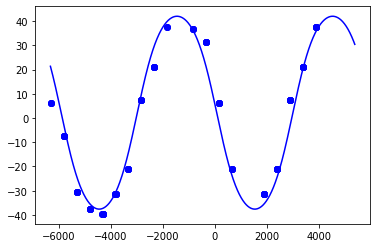

In [159]:
guess = np.zeros(4)
guess[3] = 5000
popt, pcov = curve_fit(fourier_series,s1,flr_tan,guess)
print(popt)
plt.plot(xi,np.rad2deg(np.arctan(fourier_series(xi,popt[0],popt[1],popt[2],popt[3]))),'b-')
plt.plot(s1,flr,'bo')

[4991.53145702 9983.65032581]


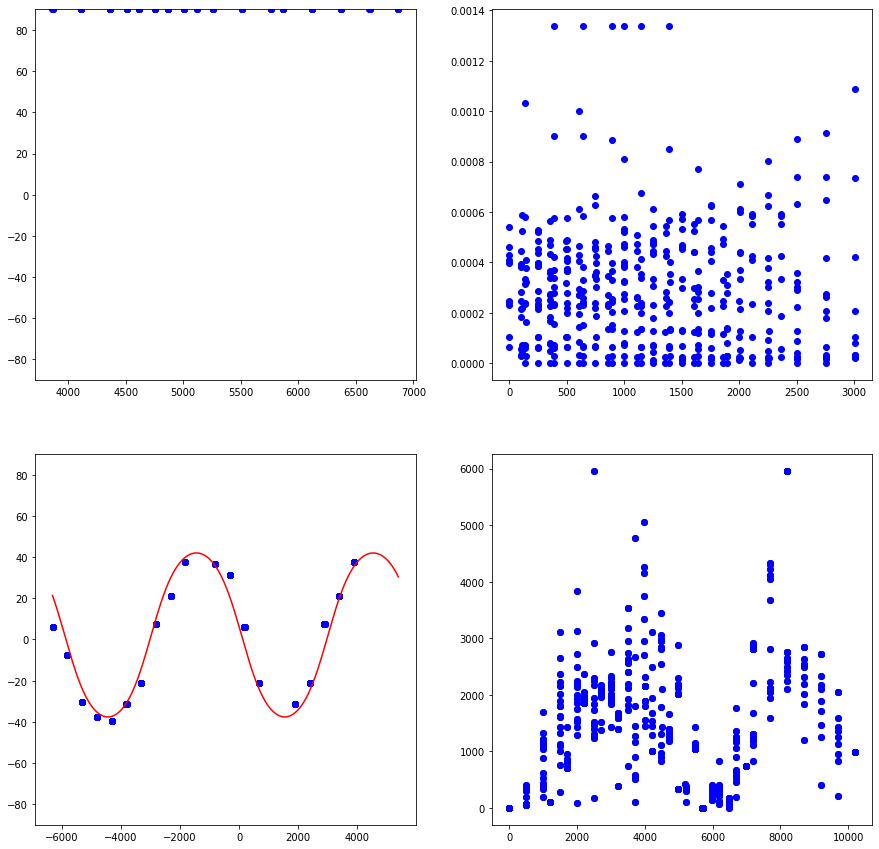

In [160]:


far = fold_frame.calculate_fold_axis_rotation(np.hstack([xyz,l1]))
s1 = fold_frame.features[0].evaluate_value(xyz)
s1gy = fold_frame.features[1].evaluate_value(xyz)
axis_svariogram = SVariogram(s1gy,far)
guess = axis_svariogram.find_wavelengths()
# guess/=2
rotation_plots = RotationAnglePlotter()
rotation_plots.add_fold_axis_data(far,s1gy)
rotation_plots.add_axis_svariogram(axis_svariogram)
def fold_axis_rotation(x):
    v = np.zeros(x.shape)
    v[:] = 0
    return v
fold.fold_axis_rotation = fold_axis_rotation
#
# # ### Evaluate the fold limb rotation angle
# # The fold axis can be queried for any location in the model. The axis is a unit vector and
# # does not need to be normalised here. THe fold limb rotation angle is calculated by finding
# # the angle between the folded foliation and the axial foliation in the fold frame. The calculated
# # axis can be used by passing an N,3 array of the fold axis for every N locations. Or if no
# # axis is specified the local intersection lineation is used.
axis = fold.get_fold_axis_orientation(xyz)
flr = fold_frame.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
limb_svariogram = SVariogram(s1,flr)
guess = np.array(limb_svariogram.find_wavelengths())
print(guess)
# guess[0] = 5000.
#guess/=2.
flr_tan = np.tan(np.deg2rad(flr))
rotation_plots.add_fold_limb_data(flr,s1)
rotation_plots.add_limb_svariogram(limb_svariogram)
# # rotation_plots.add_fold_limb_curve(np.rad2deg(np.arctan(rbf_fold_limb(xi,np.zeros(1000),np.zeros(1000)))), xi)
# #
# # plt.show()
# # rotation_plots.add_fold_axis_curve(np.rad2deg(np.arctan(rbf_fold_axis(xi,np.zeros(1000),np.zeros(1000)))), xi)
rotation_plots.add_fold_limb_data(flr,s1)
rotation_plots.add_limb_svariogram(limb_svariogram)
rbf_fold_limb = Rbf(s1,np.zeros(s1.shape),np.zeros(s1.shape),flr_tan,
                    function='gaussian',
                    epsilon=guess[1],
                   smooth=0.001)
xi = np.linspace(faulted_fold_frame.features[0].min(),faulted_fold_frame.features[0].max(),1000)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))
    #return np.rad2deg(np.arctan(rbf_fold_limb(x,np.zeros(x.shape),np.zeros(x.shape))))

rotation_plots.add_fold_limb_curve(fold_limb_rotation(xi), xi)
plt.show()
fold.fold_limb_rotation = fold_limb_rotation

The fold rotation angle function is added to the **FoldEvent**<br>
# fold.fold_limb_rotation = fold_limb_rotation

In [161]:
# ### Define interpolation weights
# The DiscreteFoldInterpolator has the ability to weigh the different geometrical properties of the
# fold differently in the least squares system. Much the same as data points and regularisation are
# handled differently for standard interpolation.
# * **fold_orientation** is the weight of the dot product between a
# * **fold_axis** is the weight of the dot product between the fold axis and the interpolated foliation
# * **fold_normalisation**
# * **fold_regularisation** is the fold regularisation term that ensures the fold is smooth along strike
# These weights need to be added to a dictionary and then passed to the feature builder along with the fold
fold_weights = {}
fold_weights['fold_orientation'] = 50.
fold_weights['fold_axis'] = 3.
fold_weights['fold_normalisation'] = 1.
fold_weights['fold_regularisation'] = 10.
folded_stratigraphy = stratigraphy_builder.build(solver=solver,
                                                 cgw=0,
                                                 fold_weights=fold_weights,
                                                 fold=fold)

In [162]:
viewer.plot_vector_data(fault_frame.features[1].support.interpolator.get_gradient_control()[:,:3],
                        fault_frame.features[1].support.interpolator.get_gradient_control()[:,3:],
                        "gy_grad",
                        colour='blue')

Object exists: gy_grad


In [163]:
folded_stratigraphy.support.interpolator.interpolation_weights

{'cgw': 0,
 'cpw': 1.0,
 'gpw': 1.0,
 'tpw': 1.0,
 'fold_weights': {'fold_orientation': 50.0,
  'fold_axis': 3.0,
  'fold_normalisation': 1.0,
  'fold_regularisation': 10.0},
 'fold': <FME.modelling.fold.fold.FoldEvent at 0x7fb7664bbeb8>,
 'cg': False}

Creating isosurface for -71.450108
Creating isosurface for 0.000000



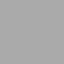

In [164]:
viewer = LavaVuModelViewer(background="white")
# viewer.plot_vector_data(strati.support.interpolator.get_gradient_control()[:,:3],
#                         strati.support.interpolator.get_gradient_control()[:,3:],
#                         "strati_grad",
#                         colour='red')
# # viewer.plot_vector_data(strati_g[:,:3],
# #                         strati_g[:,3:],
# #                         "strati_grad1",
# #                         colour='black')
# viewer.plot_isosurface(fold_frame.features[0],  colour='black',isovalue=0)
# viewer.plot_isosurface(faulted_fold_frame.features[0],  colour='purple',isovalue=0)
# viewer.plot_value_data(fault_frame.features[0].support.interpolator.get_control_points()[:,:3],
#                        fault_frame.features[0].support.interpolator.get_control_points()[:,3],
#                        'fault_data')
# viewer.plot_value_data(strati.support.interpolator.get_control_points()[:,:3],
#                        strati.support.interpolator.get_control_points()[:,3],
#                        'strati_data')
# # viewer.plot_isosurface(fold_frame.features[1],  colour='red')
# # viewer.plot_vector_data(fold_frame.features[0].support.interpolator.get_gradient_control()[:,:3],
# #                         fold_frame.features[0].support.interpolator.get_gradient_control()[:,3:],
# #                         "gx_grad")
# # viewer.plot_vector_data(fold_frame.features[1].support.interpolator.get_gradient_control()[:,:3],
# #                         fold_frame.features[1].support.interpolator.get_gradient_control()[:,3:],
# #                         "gy_grad",
# #                         colour='red')
viewer.plot_vector_data(stratigraphy_builder.interpolator.get_gradient_control()[:,:3],
                        stratigraphy_builder.interpolator.get_gradient_control()[:,3:],
                        "s0",
                        colour='pink',
                        size=4)
viewer.plot_isosurface(folded_stratigraphy,
                       colour='purple'
                       # paint_with=f1_frame.features[0]
                       )
viewer.plot_isosurface(faulted_strati,
                       colour='green'
                       # paint_with=f1_frame.features[0]
                       )
# viewer.plot_isosurface(fault_frame.features[0],  colour='green', isovalue=0)
# viewer.plot_isosurface(fault_frame.features[1],  colour='blue')
# viewer.plot_vector_data(fault_frame.features[0].support.interpolator.get_gradient_control()[:,:3],
#                         fault_frame.features[0].support.interpolator.get_gradient_control()[:,3:],
#                         "gx_grad",colour='green')
# viewer.plot_vector_data(fault_frame.features[1].support.interpolator.get_gradient_control()[:,:3],
#                         fault_frame.features[1].support.interpolator.get_gradient_control()[:,3:],
#                         "gy_grad",
#                         colour='blue')
# viewer.plot_isosurface(fold_frame.features[0],  colour='black',isovalue=0)
# viewer.plot_isosurface(faulted_fold_frame.features[0],  colour='purple',isovalue=0)
# locations = mesh.barycentre[::20,:]
# # viewer.plot_vector_field(f1_frame.features[2], locations=locations, colour='red')
# viewer.plot_vector_field(fault_frame.features[1], locations=locations, colour='blue')
# # viewer.plot_vector_field(f1_frame.features[0], locations=locations, colour='blue')
viewer.interactive()
# #